In [528]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import random
import time
import pickle
import sys
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from ast import literal_eval

%matplotlib inline
sys.setrecursionlimit(50000)


### Loading & Modifying the DataFrame to Include additional columns

In [473]:
df_movies = pd.read_csv('Movies_listv3.csv',parse_dates=[7])

# df_movies['Year'] = df_movies['Release Date'].dt.year
df_movies.rename(columns={'Franchise Ranking':'Franchise','Brand Ranking':'Brand'},inplace=True)

print(df_movies.shape)
print(df_movies.columns)

# df_movies.dtypes

#Target Variable
y = 'Opening Weekend Gross'

# df_movies_features = df_movies.drop(columns='Opening Weekend Gross').copy()
# df_movies_target = df_movies['Opening Weekend Gross'].copy()

#column list with target at the end
cols_list = df_movies.drop(columns='Opening Weekend Gross').columns.tolist()+['Opening Weekend Gross']
cols_list

(6280, 17)
Index(['Release Link', 'Title', 'Domestic Gross', 'Max Theatres',
       'Opening Weekend Gross', 'Domestic to Opening Gross',
       'Opening Weekend Theatres', 'Release Date', 'Studio Link',
       'Studio Name', 'Title ID', 'Running Length', 'Budget', 'MPAA', 'Genre',
       'Franchise', 'Brand'],
      dtype='object')


['Release Link',
 'Title',
 'Domestic Gross',
 'Max Theatres',
 'Domestic to Opening Gross',
 'Opening Weekend Theatres',
 'Release Date',
 'Studio Link',
 'Studio Name',
 'Title ID',
 'Running Length',
 'Budget',
 'MPAA',
 'Genre',
 'Franchise',
 'Brand',
 'Opening Weekend Gross']

### Exploratory Data Analysis

In [436]:
df_movies.describe()

,Domestic Gross,Opening Weekend Gross,Domestic to Opening Gross,Running Length,Budget,Franchise,Brand
count,6.280000e+03,6.280000e+03,6280.000000,6098.000000,2.426000e+03,6280.000000,6280.000000
mean,1.727190e+07,5.205487e+06,0.283905,105.553460,3.538708e+07,0.067834,0.064331
std,5.493935e+07,1.787751e+07,0.236398,30.444267,5.013210e+07,0.251482,0.245362
min,7.200000e+01,0.000000e+00,0.000000,61.000000,0.000000e+00,0.000000,0.000000
25%,2.502400e+04,4.755500e+03,0.074000,91.000000,4.500000e+06,0.000000,0.000000
50%,1.841175e+05,2.409600e+04,0.259000,101.000000,1.500000e+07,0.000000,0.000000
75%,3.705458e+06,5.050545e+05,0.430000,114.000000,4.000000e+07,0.000000,0.000000
max,9.366622e+08,3.571150e+08,1.891000,1179.000000,3.560000e+08,1.000000,1.000000


In [437]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6280 entries, 0 to 6279
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Release Link               6280 non-null   object        
 1   Title                      6280 non-null   object        
 2   Domestic Gross             6280 non-null   int64         
 3   Max Theatres               6280 non-null   object        
 4   Opening Weekend Gross      6280 non-null   int64         
 5   Domestic to Opening Gross  6280 non-null   float64       
 6   Opening Weekend Theatres   6280 non-null   object        
 7   Release Date               6280 non-null   datetime64[ns]
 8   Studio Link                6280 non-null   object        
 9   Studio Name                6280 non-null   object        
 10  Title ID                   6260 non-null   object        
 11  Running Length             6098 non-null   float64       
 12  Budget

----
Based on the above tables, 
The max **running length** is 1179 minutes, which does not seem plausible. This merits further exploring.  
**Budget** maximum is magnitudes higher than the 75% mark.
Additionally, there are a lot of **missing values** for **Budget & MPAA** & a few for **Running Length & Genre**

Lastly, **Opening Weekend Theatres** are being read as **object** columns, whereas they should be integers. This requires some data cleaning!


### Opening Weekend Theatres

In [428]:
mask_non_numeric_theatres = ~(df_movies['Opening Weekend Theatres'].str.isnumeric())
df_movies_non_numeric_theatres = df_movies[mask_non_numeric_theatres]
print(df_movies_non_numeric_theatres.shape)
df_movies_non_numeric_theatres.sort_values(by='Budget',ascending=False)

(486, 17)


,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand
4759,https://www.boxofficemojo.com//release/rl20168...,The Polar Express2017 IMAX Release,875150,-,1321,0.002,-,2017-11-17,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
2207,https://www.boxofficemojo.com//release/rl35904...,The Polar Express2013 IMAX Release,493776,-,0,0.000,-,2013-11-09,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
2856,https://www.boxofficemojo.com//release/rl36072...,The Polar Express2014 IMAX Release,139055,-,0,0.000,-,2014-11-01,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
4150,https://www.boxofficemojo.com//release/rl35233...,The Polar Express2016 IMAX Release,765154,129,0,0.000,-,2016-11-11,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
3480,https://www.boxofficemojo.com//release/rl33555...,The Polar Express2015 IMAX Release,846602,-,0,0.000,-,2015-11-19,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
3477,https://www.boxofficemojo.com//release/rl56187...,Wolf Totem,210591,5,0,0.000,-,2015-09-11,https://pro.imdb.com/company/co0026545/boxoffi...,Sony Pictures Entertainment (SPE),tt2909116,121.0,38000000.0,['PG-13'],"['Adventure', 'Drama']",0.0,0.0
5592,https://www.boxofficemojo.com//release/rl31208...,Son of Bigfoot,289308,30,0,0.000,-,2018-03-30,https://pro.imdb.com/company/co0310474/boxoffi...,Viva Pictures,tt5715410,92.0,30000000.0,['PG'],"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
3476,https://www.boxofficemojo.com//release/rl55346...,Dark Places,208588,151,0,0.000,-,2015-08-07,https://pro.imdb.com/company/co0390816/boxoffi...,A24,tt2402101,113.0,20000000.0,['R'],"['Crime', 'Drama', 'Mystery', 'Thriller']",0.0,0.0
2846,https://www.boxofficemojo.com//release/rl32796...,Wolves,12139,12,0,0.000,-,2014-11-14,https://pro.imdb.com/company/co0368766/boxoffi...,Ketchup Entertainment,tt1403241,91.0,18000000.0,['R'],"['Action', 'Fantasy', 'Horror', 'Romance', 'Th...",0.0,0.0
1007,https://www.boxofficemojo.com//release/rl19028...,The Pool Boys,2269,101,0,0.000,-,2011-09-30,https://pro.imdb.com/company/co0287297/boxoffi...,Cinedigm Entertainment Group,tt0807028,107.0,15000000.0,['R'],['Comedy'],0.0,0.0


Since Opening Weekend Theatres is a vital to predicting how much a movie would make in its Opening Weekend, rows without this information will be dropped.

Also, Looks like the top few budget movies with no 'Opening Weekend Theatres' are IMAX and/or re-releases. It would be prudent to remove any movie title with the word 'release' or 'IMAX' in it, as that would be indicative of duplicates.

In [474]:
df_movies = df_movies.drop(df_movies_non_numeric_theatres.index).reset_index(drop = True)
df_movies['Opening Weekend Theatres'] = df_movies['Opening Weekend Theatres'].astype('int64')
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5794 entries, 0 to 5793
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Release Link               5794 non-null   object        
 1   Title                      5794 non-null   object        
 2   Domestic Gross             5794 non-null   int64         
 3   Max Theatres               5794 non-null   object        
 4   Opening Weekend Gross      5794 non-null   int64         
 5   Domestic to Opening Gross  5794 non-null   float64       
 6   Opening Weekend Theatres   5794 non-null   int64         
 7   Release Date               5794 non-null   datetime64[ns]
 8   Studio Link                5794 non-null   object        
 9   Studio Name                5794 non-null   object        
 10  Title ID                   5781 non-null   object        
 11  Running Length             5648 non-null   float64       
 12  Budget

In [475]:
#dropping movies with "Release" in their title"
df_movies[df_movies.Title.str.contains('Release|IMAX',case=False,regex=True)]

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand
195,https://www.boxofficemojo.com//release/rl51036...,The Polar Express2010 IMAX Release,672796,17,80505,0.120,15,2010-12-03,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
497,https://www.boxofficemojo.com//release/rl37139...,The Lion King2011 3D Release,94242001,2340,30151614,0.320,2330,2011-09-16,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt0110357,88.0,45000000.0,['G'],"['Adventure', 'Animation', 'Drama', 'Family', ...",0.0,0.0
706,https://www.boxofficemojo.com//release/rl52714...,The Polar Express2011 IMAX Release,711168,25,55299,0.078,19,2011-11-25,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0
1034,https://www.boxofficemojo.com//release/rl13496...,Star Wars: Episode I - The Phantom Menace2012 ...,43456382,2655,22469932,0.517,2655,2012-02-10,https://pro.imdb.com/company/co0000756/boxoffi...,Twentieth Century Fox,tt0120915,136.0,115000000.0,['PG'],"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",1.0,1.0
1048,https://www.boxofficemojo.com//release/rl25614...,Beauty and the Beast2012 3D Release,47617067,2625,17751905,0.373,2625,2012-01-13,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt0101414,84.0,25000000.0,NaN,"['Animation', 'Family', 'Fantasy', 'Musical', ...",0.0,0.0
1052,https://www.boxofficemojo.com//release/rl37154...,Titanic2012 3D Release,57884114,3674,17285453,0.299,2674,2012-04-04,https://pro.imdb.com/company/co0023400/boxoffi...,Paramount Pictures,tt0120338,194.0,200000000.0,['PG-13'],"['Drama', 'Romance']",0.0,0.0
1054,https://www.boxofficemojo.com//release/rl27066...,Finding Nemo2012 3D Release,41128283,2904,16687773,0.406,2904,2012-09-14,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt0266543,100.0,94000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family']",1.0,1.0
1106,https://www.boxofficemojo.com//release/rl20366...,"Monsters, Inc.2012 3D Release",34043006,2618,4774686,0.140,2618,2012-12-19,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt0198781,92.0,115000000.0,['G'],"['Adventure', 'Animation', 'Comedy', 'Family',...",1.0,1.0
1126,https://www.boxofficemojo.com//release/rl40670...,Raiders of the Lost Ark2012 IMAX Release,3125613,322,1673731,0.535,267,2012-09-07,https://pro.imdb.com/company/co0023400/boxoffi...,Paramount Pictures,tt0082971,115.0,18000000.0,['PG'],"['Action', 'Adventure']",1.0,1.0
1216,https://www.boxofficemojo.com//release/rl27548...,The Polar Express2012 IMAX Release,669289,17,73514,0.110,15,2012-11-21,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt0338348,100.0,165000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,0.0


All of the above movies are "Re-releases" of existing movies. Hence they will be dropped from the dataset.

In [476]:
df_movies = df_movies.drop(df_movies[df_movies.Title.str.contains('Release|IMAX',case=False,regex=True)].index).reset_index(drop=True)


### Budget

Since Budget accounts for the largest # of missing values, we can examine this to see if we want drop rows or keep, and proceed accordingly. 

In [477]:
mask_budget_na = (df_movies.Budget.isna()) | (df_movies.Budget==0)
df_movies[mask_budget_na].describe()

,Domestic Gross,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Running Length,Budget,Franchise,Brand
count,3.444000e+03,3.444000e+03,3444.000000,3444.000000,3337.000000,1.0,3444.000000,3444.000000
mean,6.400839e+05,1.344683e+05,0.300714,50.623403,104.487264,0.0,0.006388,0.014228
std,2.325289e+06,6.486394e+05,0.248728,198.214474,30.475664,NaN,0.079680,0.118445
min,7.200000e+01,0.000000e+00,0.000000,1.000000,61.000000,0.0,0.000000,0.000000
25%,1.729775e+04,4.519500e+03,0.093000,1.000000,90.000000,0.0,0.000000,0.000000
50%,6.834600e+04,1.187700e+04,0.232000,3.000000,99.000000,0.0,0.000000,0.000000
75%,3.394680e+05,4.815175e+04,0.465250,14.000000,112.000000,0.0,0.000000,0.000000
max,5.252290e+07,2.164168e+07,1.891000,3020.000000,808.000000,0.0,1.000000,1.000000


Based on the above table, looks like atleast 75% of the movies with no budget info were released in 14 theatres or less & made less than 48000 on opening weekend, indicating they are very niche movies. 

In [478]:
mask_budget_na = ((df_movies.Budget.isna()) | (df_movies.Budget==0)) & (df_movies['Opening Weekend Theatres'] > 14)
df_movies[mask_budget_na].sort_values(by='Opening Weekend Theatres',ascending=False)

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand
2833,https://www.boxofficemojo.com//release/rl22560...,Strange Magic,12429583,3020,5504441,0.443,3020,2015-01-23,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt4191054,99.0,NaN,['PG'],"['Adventure', 'Animation', 'Comedy', 'Family',...",0.0,1.0
5291,https://www.boxofficemojo.com//release/rl53723...,Arctic Dogs,5801249,2844,2901335,0.500,2844,2019-11-01,https://pro.imdb.com/company/co0608498/boxoffi...,Entertainment Studios Motion Pictures,tt4426464,92.0,NaN,['PG'],"['Adventure', 'Animation', 'Comedy', 'Family']",0.0,0.0
3410,https://www.boxofficemojo.com//release/rl31455...,The Choice,18730891,2631,6050443,0.323,2631,2016-02-05,https://pro.imdb.com/company/co0173285/boxoffi...,Lionsgate,tt3797868,111.0,NaN,['PG-13'],"['Drama', 'Romance']",0.0,1.0
1108,https://www.boxofficemojo.com//release/rl33952...,Won't Back Down,5310554,2517,2603370,0.490,2515,2012-09-28,https://pro.imdb.com/company/co0000756/boxoffi...,Twentieth Century Fox,tt1870529,121.0,NaN,['PG'],['Drama'],0.0,1.0
5279,https://www.boxofficemojo.com//release/rl14600...,Greta,10532219,2417,4481910,0.426,2411,2019-03-01,https://pro.imdb.com/company/co0042399/boxoffi...,Focus Features,tt2639336,98.0,NaN,['R'],"['Drama', 'Mystery', 'Thriller']",0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3111,https://www.boxofficemojo.com//release/rl71096...,"Love, Rosie",20431,15,14893,0.729,15,2015-02-06,https://pro.imdb.com/company/co0373736/boxoffi...,The Film Arcade,tt1638002,102.0,NaN,['R'],"['Comedy', 'Romance']",0.0,0.0
3070,https://www.boxofficemojo.com//release/rl17599...,Madame Bovary,44235,15,20841,0.471,15,2015-06-12,https://pro.imdb.com/company/co0140583/boxoffi...,Alchemy,tt2334733,118.0,NaN,['R'],"['Drama', 'Romance']",0.0,0.0
3029,https://www.boxofficemojo.com//release/rl32294...,The Office,63675,15,34144,0.536,15,2015-09-18,https://pro.imdb.com/company/co0316267/boxoffi...,China Lion Film Distribution,tt4392726,119.0,NaN,NaN,"['Comedy', 'Musical', 'Romance']",0.0,0.0
3024,https://www.boxofficemojo.com//release/rl72663...,Deli Man,502294,38,37321,0.074,15,2015-02-27,https://pro.imdb.com/company/co0243890/boxoffi...,Cohen Media Group,tt4239548,92.0,NaN,['PG-13'],['Documentary'],0.0,0.0


Based on looking at the data, a majority of the movies with no budget are either niche or a foreign film being released in USA.  
Additionally, the budget of a movie highly correlates to the marketing a movie would recieve, hence it is a very important indicator for the opening gross of the movie. For that reason, it is being dropped for now.  

Perhaps an imputation strategy can be undertaken to fill the budget values.

In [482]:
budget_na_mask = ((df_movies.Budget.isna()) | (df_movies.Budget==0))

df_movies = df_movies[~budget_na_mask].reset_index(drop=True)


In [483]:
df_movies.describe()

,Domestic Gross,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Running Length,Budget,Franchise,Brand
count,2.329000e+03,2.329000e+03,2329.000000,2329.000000,2291.000000,2.329000e+03,2329.000000,2329.000000
mean,4.541426e+07,1.378551e+07,0.315625,1590.108630,107.143169,3.583159e+07,0.165736,0.150708
std,8.285621e+07,2.726435e+07,0.199276,1566.823184,18.237888,5.007006e+07,0.371924,0.357841
min,1.470000e+02,0.000000e+00,0.000000,1.000000,62.000000,1.800000e+01,0.000000,0.000000
25%,3.746750e+05,4.805900e+04,0.179000,5.000000,94.000000,5.000000e+06,0.000000,0.000000
50%,1.439410e+07,3.024399e+06,0.324000,1473.000000,104.000000,1.600000e+07,0.000000,0.000000
75%,5.386296e+07,1.619474e+07,0.427000,3055.000000,117.000000,4.000000e+07,0.000000,0.000000
max,9.366622e+08,3.571150e+08,1.169000,4725.000000,334.000000,3.560000e+08,1.000000,1.000000



### Running Length

Mainstream movies that are released in theatres rarely longer than 3 hours. Adding 20 minutes for credits, let's look at how many movies are more than 200 minutes

In [486]:
df_movies[df_movies['Running Length'] > 200].sort_values(by='Running Length',ascending=False)

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand
207,https://www.boxofficemojo.com//release/rl13637...,Carlos,145526,7,20006,0.137,2,2010-10-15,https://pro.imdb.com/company/co0015762/boxoffi...,IFC Films,tt1321865,334.0,18000000.0,NaN,"['Biography', 'Crime', 'Drama', 'Thriller']",0.0,0.0
2294,https://www.boxofficemojo.com//release/rl39869...,The Godfather: Part II45th Anniversary,291754,681,171417,0.588,681,2019-11-10,https://pro.imdb.com/company/co0360057/boxoffi...,Fathom Events,tt0071562,202.0,13000000.0,NaN,"['Crime', 'Drama']",1.0,0.0


After removing 'na' budget values, only 2 movies with a run time of more 200 mins remain. One of them is a re-re-release and the other is actually a mini-series based on research. Hence, both o them shall be dropped.  

Addtionally, a search based on the word "Anniversary" should be done to check for re-releases too.

In [491]:
df_movies = df_movies.drop(df_movies[df_movies['Running Length'] > 200].index).reset_index(drop=True)

In [492]:
#checking movies with "Anniversary" in their title"
df_movies[df_movies.Title.str.contains('Anniversary',case=False,regex=True)]

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand
745,https://www.boxofficemojo.com//release/rl64327...,The Graduate45th Anniversary Reunion,43466,2,5778,0.133,1,2012-04-11,https://pro.imdb.com/company/co0049592/boxoffi...,Rialto Pictures,tt0061722,106.0,3000000.0,['PG'],"['Comedy', 'Drama', 'Romance']",0.0,0.0
2290,https://www.boxofficemojo.com//release/rl34673...,Meet Me in St. Louis75th Anniversary,403521,679,225684,0.559,679,2019-12-08,https://pro.imdb.com/company/co0360057/boxoffi...,Fathom Events,tt0037059,113.0,1700000.0,NaN,"['Comedy', 'Drama', 'Family', 'Music', 'Romance']",0.0,0.0
2294,https://www.boxofficemojo.com//release/rl30308...,When Harry Met Sally...30th Anniversary,252320,660,157660,0.625,660,2019-12-01,https://pro.imdb.com/company/co0360057/boxoffi...,Fathom Events,tt0098635,95.0,16000000.0,NaN,"['Comedy', 'Drama', 'Romance']",0.0,0.0


All three movies are re-releases, hence they are being dropped

In [493]:
df_movies = df_movies.drop(df_movies[df_movies.Title.str.contains('Anniversary',case=False,regex=True)].index).reset_index(drop=True)


### Genres Encoding

Checking for Nulls & encoding Genres into numberical columns

In [562]:
# df_movies.Genre.apply(literal_eval)

genre_dict = defaultdict(int)
for genre_combo in df_movies.Genre:
    for genre in genre_combo:
        genre_dict[genre] += 1
        
sorted(genre_dict.items(),key=lambda x: x[1],reverse=True)
genre_series = pd.Series(genre_dict)

In [572]:
genre_series/genre_series.sum()

Drama          0.182649
Comedy         0.113594
Thriller       0.097200
Action         0.089221
Adventure      0.068185
Romance        0.059916
Crime          0.051356
Fantasy        0.044393
Sci-Fi         0.039605
Mystery        0.039025
Horror         0.038010
Family         0.036994
Biography      0.033077
History        0.020456
Animation      0.020165
Documentary    0.016393
War            0.014217
Music          0.012186
Sport          0.010010
Musical        0.007979
Western        0.004352
News           0.000725
Film-Noir      0.000290
dtype: float64


### MPAA Rating

MPAA values are analyzed to check for nulls & encode them into numerical columns

In [502]:
df_movies[df_movies.MPAA.isna()]

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand
3,https://www.boxofficemojo.com//release/rl13835...,Toy Story 3,415004880,4028,110307189,0.266,4028,2010-06-18,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt0435761,103.0,200000000.0,NaN,"['Adventure', 'Animation', 'Comedy', 'Family',...",1.0,1.0
102,https://www.boxofficemojo.com//release/rl35301...,Ramona and Beezus,26167002,2719,7810481,0.298,2719,2010-07-23,https://pro.imdb.com/company/co0000756/boxoffi...,Twentieth Century Fox,tt0493949,104.0,15000000.0,NaN,"['Comedy', 'Drama', 'Family', 'Fantasy']",0.0,1.0
111,https://www.boxofficemojo.com//release/rl66103...,Oceans,19422319,1232,6058958,0.312,1206,2010-04-22,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt0765128,104.0,80000000.0,NaN,"['Documentary', 'Drama']",0.0,1.0
127,https://www.boxofficemojo.com//release/rl36625...,Fearless,1288549,68,628137,0.487,62,2010-09-10,https://pro.imdb.com/company/co0050176/boxoffi...,Eros International,tt1620719,126.0,9370000.0,NaN,"['Action', 'Comedy']",0.0,0.0
128,https://www.boxofficemojo.com//release/rl40342...,Tees Maar Khan,1076443,108,539793,0.501,108,2010-12-22,https://pro.imdb.com/company/co0131238/boxoffi...,UTV Motion Pictures,tt1572311,135.0,4200000.0,NaN,"['Comedy', 'Crime']",0.0,0.0
175,https://www.boxofficemojo.com//release/rl36292...,Enter the Void,336467,13,43651,0.130,3,2010-09-24,https://pro.imdb.com/company/co0015762/boxoffi...,IFC Films,tt1191111,161.0,16000000.0,NaN,"['Drama', 'Fantasy']",0.0,0.0
181,https://www.boxofficemojo.com//release/rl46022...,The Secret of Kells,676775,37,39826,0.059,1,2010-03-05,https://pro.imdb.com/company/co0255038/boxoffi...,GKIDS,tt0485601,71.0,8000000.0,NaN,"['Adventure', 'Animation', 'Family', 'Fantasy']",0.0,0.0
188,https://www.boxofficemojo.com//release/rl42824...,Ajami,622403,23,35792,0.058,3,2010-02-03,https://pro.imdb.com/company/co0047947/boxoffi...,Kino International,tt1077262,124.0,1000000.0,NaN,"['Crime', 'Drama']",0.0,0.0
199,https://www.boxofficemojo.com//release/rl39145...,Fish Tank,374675,15,25854,0.069,2,2010-01-15,https://pro.imdb.com/company/co0015762/boxoffi...,IFC Films,tt1232776,123.0,3000000.0,NaN,['Drama'],0.0,0.0
202,https://www.boxofficemojo.com//release/rl30838...,Living in Emergency,32208,7,21905,0.680,7,2010-06-04,https://pro.imdb.com/company/co0179468/boxoffi...,Truly Indie,tt1294182,93.0,2000000.0,NaN,['Documentary'],0.0,0.0


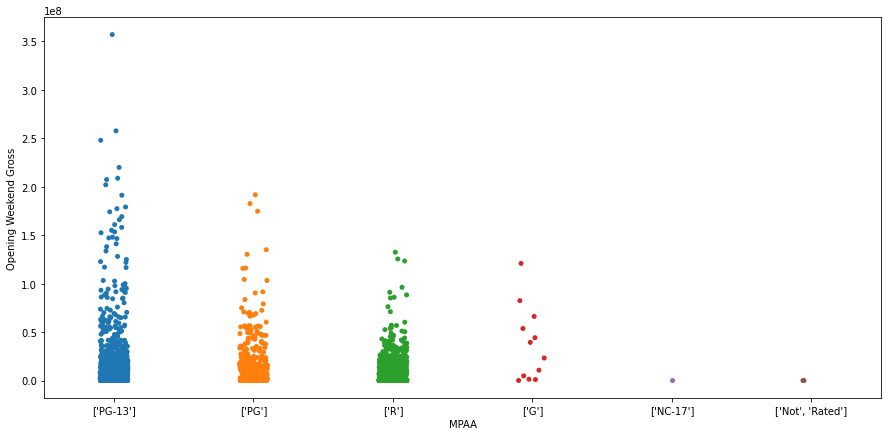

In [533]:
plt.figure(figsize=(15,7))
sns.stripplot(x='MPAA',y='Opening Weekend Gross',data=df_movies);

If the movie has a PG-13 or PG rating, it is encoded to a value of 2, else if it has a value of 'R', it is encoded to 1, else it is given a value of 0; in a new column named **'MPAA Code'**  
The thought here is that the former allows for family with kids viewing, providing access to a greater share of potential audience, while the later is restricted in terms of the audience it can tap into.

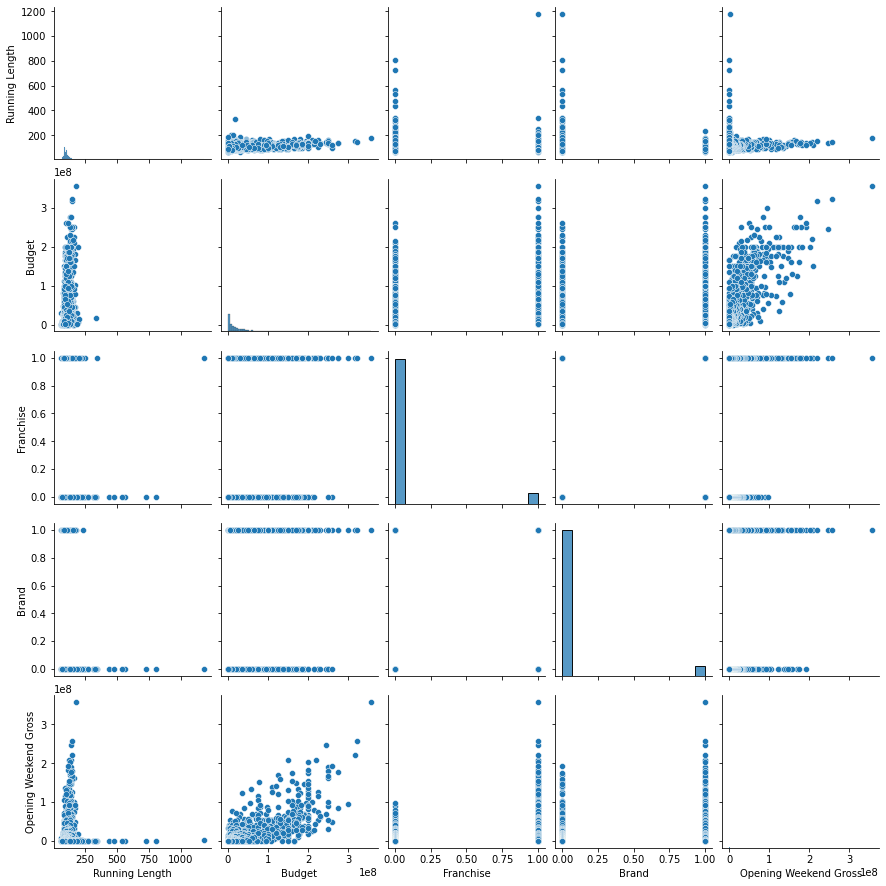

In [377]:
sns.pairplot(data=df_movies[cols_list].drop(columns=['Domestic to Opening Gross','Domestic Gross']), \
                                            diag_kind='hist')


### Franchise

In [375]:
df_movies.groupby('Franchise')[['Opening Weekend Gross','Budget']].agg(['count','mean'])

Opening Weekend Gross               Budget              
                          count          mean  count          mean
Franchise                                                         
0.0                        5854  2.295226e+06   2029  2.464357e+07
1.0                         426  4.519767e+07    397  9.029534e+07

Looks like almost 8% of the movies belong to a franchise; which is great!  
Not too much of the dataset has that variable as 1, hence the column could be helpful in differentiating the prediction.  
Additionally, it is quite evident that on average, Franchise movies earn a magnitude higher than non-franchise movies  

Additionally, Franchise movies seem to have a higher budget too; indicating an interaction. Multiplying the two will definitely help!


### Brand

In [374]:
df_movies.groupby('Brand')[['Opening Weekend Gross','Budget']].agg(['count','mean'])

Opening Weekend Gross               Budget              
                      count          mean  count          mean
Brand                                                         
0.0                    5876  3.044329e+06   2071  2.713438e+07
1.0                     404  3.663858e+07    355  8.353169e+07

Just like Franchise, looks like almost 7% of the movies belong to a franchise; which is great!  
Not too much of the dataset has that variable as 1, hence the column could be helpful in differentiating the prediction.
Also, Brand movies also earn earn a magnitude higher than non-Brand movies.


### Running Length

In [381]:
df_movies.sort_values(by='Running Length',ascending=False).head(15)

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand
3656,https://www.boxofficemojo.com//release/rl11745...,Harry Potter IMAX Marathon,1729226,330,1357376,0.785,330,2016-10-14,https://pro.imdb.com/company/co0057495/boxoffi...,IMAX,NaN,1179.0,NaN,NaN,NaN,1.0,0.0
6153,https://www.boxofficemojo.com//release/rl47051...,La Flor,4032,1,2308,0.572,1,2019-08-09,https://pro.imdb.com/company/co0575901/boxoffi...,Grasshopper Film,tt9047474,808.0,NaN,NaN,"['Drama', 'Fantasy', 'Musical', 'Mystery', 'Ro...",0.0,0.0
3267,https://www.boxofficemojo.com//release/rl27596...,Out 1,31539,4,12537,0.398,4,2015-11-06,https://pro.imdb.com/company/co0037047/boxoffi...,Carlotta Films,tt0246135,729.0,NaN,NaN,"['Drama', 'Mystery']",0.0,0.0
413,https://www.boxofficemojo.com//release/rl10644...,Shoah,20175,1,2874,0.142,1,2010-12-10,https://pro.imdb.com/company/co0015762/boxoffi...,IFC Films,tt0090015,566.0,NaN,NaN,"['Documentary', 'History', 'War']",0.0,0.0
3466,https://www.boxofficemojo.com//release/rl29273...,Rediscover SautetFilm Festival,25314,1,0,0.000,-,2015-06-12,https://pro.imdb.com/company/co0049592/boxoffi...,Rialto Pictures,NaN,536.0,NaN,NaN,NaN,0.0,0.0
5366,https://www.boxofficemojo.com//release/rl62105...,Eight Hours Don't Make a Day,19987,1,5880,0.294,1,2018-03-16,https://pro.imdb.com/company/co0052424/boxoffi...,Janus Films,tt0068028,476.0,NaN,NaN,['Drama'],0.0,0.0
4595,https://www.boxofficemojo.com//release/rl98989...,Marius/Fanny/César,24787,1,7720,0.311,1,2017-01-04,https://pro.imdb.com/company/co0052424/boxoffi...,Janus Films,NaN,438.0,NaN,NaN,NaN,0.0,0.0
3473,https://www.boxofficemojo.com//release/rl14510...,Back To The Future DayTriple Bill,1650000,1815,0,0.000,-,2015-10-21,https://pro.imdb.com/company/co0035519/boxoffi...,Universal Home Video,NaN,342.0,NaN,NaN,NaN,1.0,0.0
5509,https://www.boxofficemojo.com//release/rl17286...,L'héritage de la chouette,12316,1,0,0.000,-,2018-11-09,https://pro.imdb.com/company/co0033000/boxoffi...,Icarus Films,tt0096615,340.0,NaN,NaN,"['Documentary', 'History']",0.0,0.0
3246,https://www.boxofficemojo.com//release/rl13968...,The Apu TrilogyTriple Bill,402723,10,16064,0.000,1,2015-05-08,https://pro.imdb.com/company/co0052424/boxoffi...,Janus Films,NaN,340.0,NaN,NaN,NaN,0.0,0.0


ConversionError: Failed to convert value(s) to axis units: ['0,1']

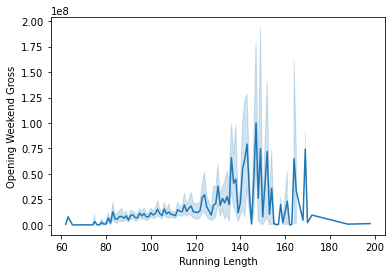

In [580]:
df_movies_less_outliers = df_movies.drop(df_movies.Budget.idxmax())
sns.lineplot(x=(df_movies_less_outliers['Running Length']),y=df_movies_less_outliers['Opening Weekend Gross'])
# plt.yticks(['0,1'])

### Encoding Studio Column

The top 6 distribution studios that are most common today are encoded to the number '1' under a new column named **'Big_Studio'**. If the studio is not one of these, it is encoded to 0. 
These 6 make up almost 80% of the market share in Domestic Gross Revenue. Morever, there is a huge cliff dropoff in the market share between the 6th & 7th ranking studio (in terms of cumulative Gross Revenue).
The idea is that these bigger studios have a greater capacity to market their movies, which will help achieve a higher opening weekend revenue.   
The list of top 6 studios were taken from the site [here](https://www.the-numbers.com/market/distributors)  

The top 6 studios are:  
Walt Disney Studios Motion Pictures  
Warner Bros.  
Sony Pictures Entertainment (SPE)  
Universal Pictures  
Twentieth Century Fox  
Paramount Pictures

<AxesSubplot:xlabel='Big_Studio', ylabel='Opening Weekend Gross'>

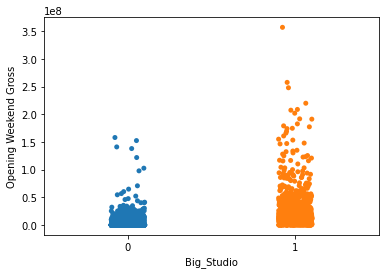

In [325]:
big_studios = ['Walt Disney Studios Motion Pictures', 'Warner Bros.', \
               'Sony Pictures Entertainment (SPE)', 'Universal Pictures', \
               'Twentieth Century Fox', 'Paramount Pictures']

df_movies['Big_Studio'] = df_movies['Studio Name'].map(lambda x:1 if x in big_studios else 0)

df_movies.head(10)

df_movies[df_movies.Big_Studio == 0].sort_values(by=y,ascending=False).head(15)

sns.stripplot(x='Big_Studio',y=y,data=df_movies);

### Encoding the MPAA Rating

If the movie has a PG-13 or PG rating, it is encoded to a value of 2, else if it has a value of 'R', it is encoded to 1, else it is given a value of 0; in a new column named **'MPAA Code'**  
The thought here is that the former allows for family with kids viewing, providing access to a greater share of potential audience, while the later is restricted in terms of the audience it can tap into.

<AxesSubplot:xlabel='MPAA', ylabel='Opening Weekend Gross'>

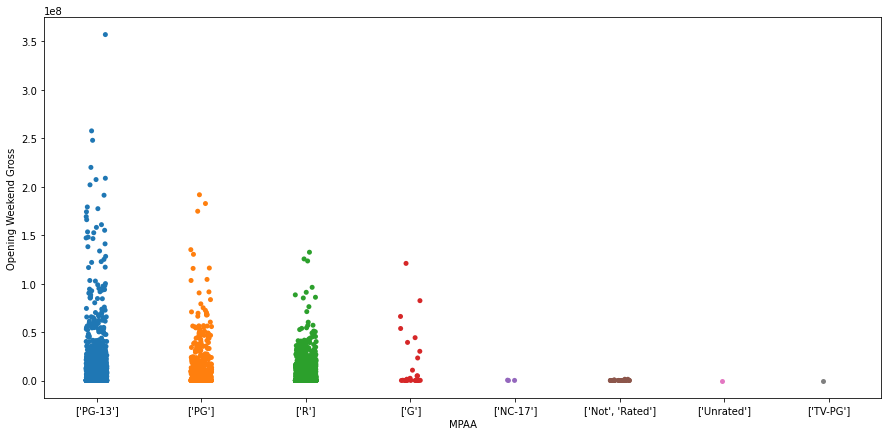

In [326]:
plt.figure(figsize=(15,7))
sns.stripplot(x='MPAA',y='Opening Weekend Gross',data=df_movies)

### Encoding the Release Dates

There are two approaches that will be taken to encode the release dates.  
The first is creating a column named **'Release_Season'**.  
November, December, May, June & July are known as blockbuster seasons, when tentpole movies with higher commercial expectations are released. Whereas, Jan, Feb, Aug, Sep are known as 'dump seasons'. So, 'Release_season' column will encode a 2 for the blockbuster season months, 0 for the dump season months and a 1 for the remaining months.  
#### Might do the below part. After MVP
Secondly, all dates that are part of a holiday weekend will be encoded as a 1 in a separate column named 'Holiday_Weekend'. The expectation is that holiday weekends generally draw larger crowds, contributing to higher grosses.   
An external dataset is used to generate all holidays for the last 10 years. 
Scrape holiday from [here](https://www.timeanddate.com/holidays/us/2020?hol=1)

<AxesSubplot:xlabel='Release_Season', ylabel='Opening Weekend Gross'>

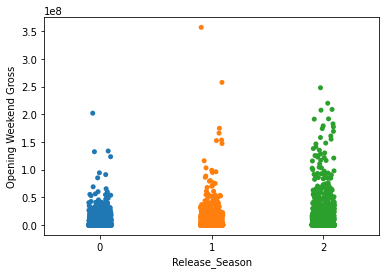

In [332]:
# Encode date to month seasonality columns
release_month_category_map = {1:0,2:0,3:1,4:1,5:2,6:2,7:2,8:0,9:0,10:1,11:2,12:2}
# df_movies['Release Date'].dt.month.map(release_month_category_map)

df_movies['Release_Season'] = df_movies['Release Date'].dt.month.map(release_month_category_map)
# df_movies
sns.stripplot(x='Release_Season',y='Opening Weekend Gross',data=df_movies)

In [329]:
df_movies[df_movies.Release_Season == 0].sort_values(by='Opening Weekend Gross',ascending=False)

,Release Link,Title,Domestic Gross,Max Theatres,Opening Weekend Gross,Domestic to Opening Gross,Opening Weekend Theatres,Release Date,Studio Link,Studio Name,Title ID,Running Length,Budget,MPAA,Genre,Franchise,Brand,Big_Studio,Release_Season
4853,https://www.boxofficemojo.com//release/rl29928...,Black Panther,700059566,4084,202003951,0.289,4020,2018-02-16,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt1825683,134.0,200000000.0,['PG-13'],"['Action', 'Adventure', 'Sci-Fi']",1.0,1.0,1,0
3519,https://www.boxofficemojo.com//release/rl11458...,Suicide Squad,325100054,4255,133682248,0.411,4255,2016-08-05,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt1386697,123.0,175000000.0,['PG-13'],"['Action', 'Adventure', 'Fantasy', 'Sci-Fi']",1.0,1.0,1,0
3520,https://www.boxofficemojo.com//release/rl25887...,Deadpool,363070709,3856,132434639,0.365,3558,2016-02-12,https://pro.imdb.com/company/co0000756/boxoffi...,Twentieth Century Fox,tt1431045,108.0,58000000.0,['R'],"['Action', 'Adventure', 'Comedy', 'Sci-Fi']",1.0,1.0,1,0
4185,https://www.boxofficemojo.com//release/rl34812...,It,327481748,4148,123403419,0.377,4103,2017-09-08,https://pro.imdb.com/company/co0002663/boxoffi...,Warner Bros.,tt1396484,135.0,35000000.0,['R'],['Horror'],1.0,1.0,1,0
2237,https://www.boxofficemojo.com//release/rl31774...,Guardians of the Galaxy,333176600,4088,94320883,0.283,4080,2014-08-01,https://pro.imdb.com/company/co0226183/boxoffi...,Walt Disney Studios Motion Pictures,tt2015381,121.0,170000000.0,['PG-13'],"['Action', 'Adventure', 'Comedy', 'Sci-Fi']",1.0,1.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4828,https://www.boxofficemojo.com//release/rl46979...,The Forest for the Trees,1410,1,0,0.000,-,2017-01-18,https://pro.imdb.com/company/co0087326/boxoffi...,Film Movement,tt0386862,81.0,NaN,NaN,['Drama'],0.0,0.0,0,0
4832,https://www.boxofficemojo.com//release/rl42280...,I Can Speak,63239,2,0,0.000,-,2017-09-22,https://pro.imdb.com/company/co0043365/boxoffi...,CJ Entertainment,tt7342204,119.0,NaN,NaN,"['Comedy', 'Drama']",0.0,0.0,0,0
4834,https://www.boxofficemojo.com//release/rl16947...,Living Proof,9512,2,0,0.000,-,2017-09-08,https://pro.imdb.com/company/co0370504/boxoffi...,GathrFilms,tt6604174,93.0,NaN,NaN,"['Biography', 'Documentary']",0.0,0.0,0,0
4835,https://www.boxofficemojo.com//release/rl42278...,Anatahan,8171,1,0,0.000,-,2017-02-03,https://pro.imdb.com/company/co0291948/boxoffi...,Kino Lorber,tt0046712,91.0,NaN,NaN,"['Drama', 'War']",0.0,0.0,0,0


In [330]:
df_movies.to_csv('Movies_List_v4.csv',index=False)

### Studio scraping

May use below code block to encode studios based on per year instead of just using the aggregate big 6 studios.  
Can also create a rolling 12 total for biggest studios from prior year, based off release date.

In [114]:
top_10_distributors = dict()
# top_10_dis = list()
for year in range(2010,2020,1):
    distributors_url = 'https://www.the-numbers.com/market/{}/distributors'

    response = requests.get(distributors_url.format(year))
    
    distributors_soup = BeautifulSoup(response.text,'html5lib')
    dist = distributors_soup.find(text=re.compile("Top Grossing")).findParent().findNext().find_all('tr')[1:11]
    
    for row in dist:
        top_10_distributors['year'] = year
        top_10_distributors['Distributor'] = row.find_all('td')[1].text
        top_10_distributors['Link'] = row.find_all('td')[1].find('a').get('href')
        top_10_distributors['Gross'] = row.find_all('td')[3].text
        
top_10_dis
top_10_distributors

{'year': 2019,
 'Distributor': 'Focus Features',
 'Link': '/market/2019/distributor/Focus-Features',
 'Gross': '$210,049,942'}

In [ ]:
# Possibly summing values from the studio grosses for last 2 years

print(df_movies.groupby(['year','Studio Name'])['Domestic Gross'].agg(['sum','mean']).sort_values(by=['year','mean'],ascending=False))